In [1]:
import re
import unicodedata
import pandas as pd
import nltk
from nltk.corpus import stopwords

from env import user, password, host
import acquire as aq
import prepare as pr

import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

# setting basic style parameters for matplotlib
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

## 1. Spam Data
    - Load the spam data set.
    - Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?
    - Is there any overlap in the bigrams for the spam data and the ham data?
    - Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [2]:
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


In [4]:
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [5]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [6]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

In [7]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [8]:
word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1
         ).fillna(0).astype(int)
word_counts.columns = ['ham','spam','all']
word_counts.head()

,ham,spam,all
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279


In [9]:
spam_bigrams = pd.Series(nltk.bigrams(spam_words))
spam_bigrams

0                   (free, entry)
1                   (entry, wkly)
2                    (wkly, comp)
3                     (comp, win)
4                       (win, fa)
                   ...           
12157        (087187272008, now1)
12158                 (now1, 10p)
12159                  (10p, per)
12160               (per, minute)
12161    (minute, btnationalrate)
Length: 12162, dtype: object

In [10]:
ham_bigrams = pd.Series(nltk.bigrams(ham_words))
ham_bigrams

0              (go, jurong)
1           (jurong, point)
2            (point, crazy)
3        (crazy, available)
4        (available, bugis)
                ...        
38136             (gave, u)
38137             (u, free)
38138          (free, rofl)
38139          (rofl, true)
38140          (true, name)
Length: 38141, dtype: object

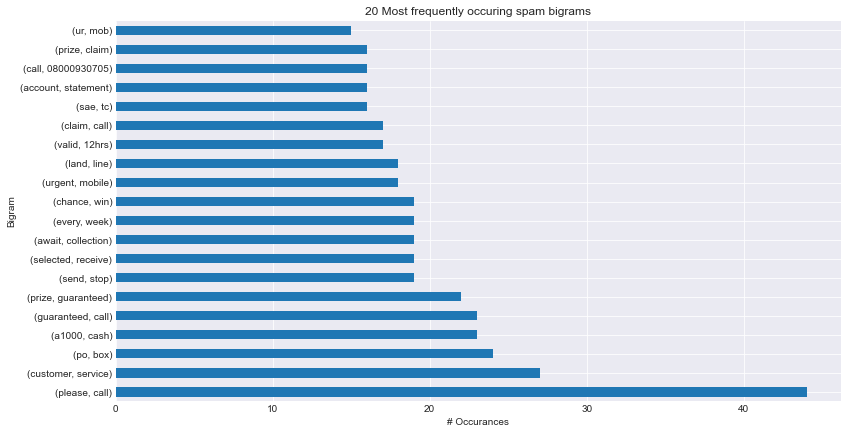

In [11]:
top20_sb = spam_bigrams.value_counts().head(20)

top20_sb.plot.barh()
plt.title('20 Most frequently occuring spam bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')
plt.show()

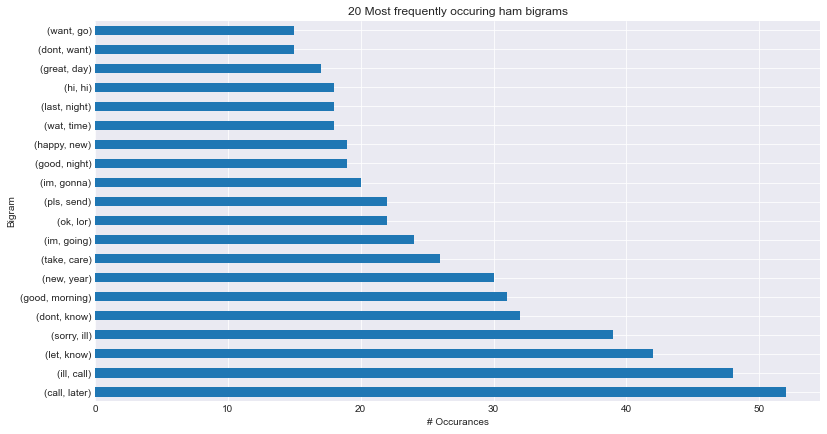

In [12]:
top20_hb = ham_bigrams.value_counts().head(20)

top20_hb.plot.barh()
plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')
plt.show()

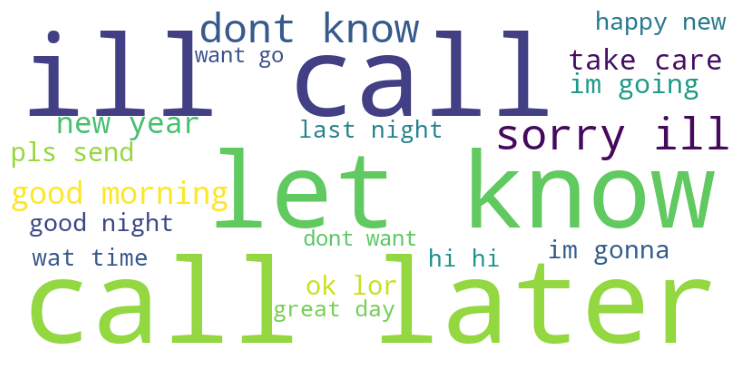

In [13]:
from wordcloud import WordCloud

data = {k[0] + ' ' + k[1]: v for k, v in top20_hb.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.imshow(img)
plt.axis('off')
plt.show()

In [14]:
ham_trigrams = pd.Series(nltk.ngrams(' '.join(ham_words).split(), 3))
ham_trigrams.value_counts()

(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(cant, pick, phone)     12
                        ..
(far, knew, wasnt)       1
(going, far, knew)       1
(keep, going, far)       1
(tag, keep, going)       1
(rofl, true, name)       1
Length: 35254, dtype: int64

In [15]:
spam_trigrams = pd.Series(nltk.ngrams(' '.join(spam_words).split(), 3))
spam_trigrams.value_counts()

(prize, guaranteed, call)     21
(call, customer, service)     15
(land, line, claim)           14
(reply, call, 08000930705)    14
(private, 2003, account)      13
                              ..
(cw25wx, 150ppm, call)         1
(326, cw25wx, 150ppm)          1
(a5000, cash, await)           1
(holiday, a5000, cash)         1
(now1, 10p, per)               1
Length: 8112, dtype: int64

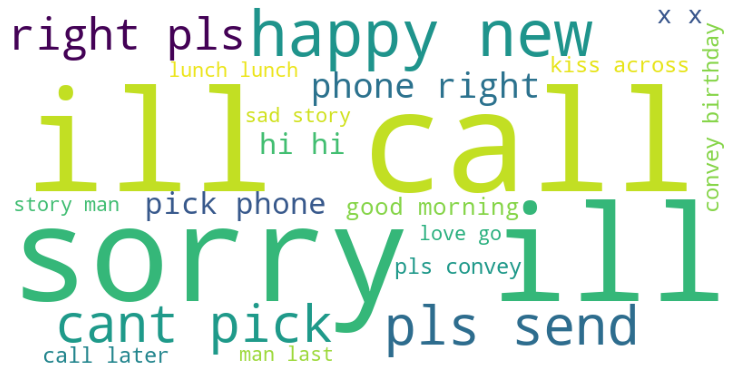

In [16]:
from wordcloud import WordCloud

top20_ht = ham_trigrams.value_counts().head(20)
data = {k[0] + ' ' + k[1]: v for k, v in top20_ht.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.imshow(img)
plt.axis('off')
plt.show()

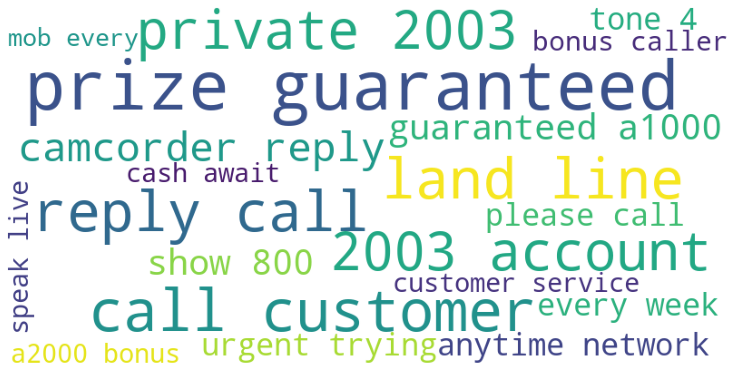

In [17]:
from wordcloud import WordCloud

top20_st = spam_trigrams.value_counts().head(20)
data = {k[0] + ' ' + k[1]: v for k, v in top20_st.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.imshow(img)
plt.axis('off')
plt.show()

## 2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [18]:
blogs = aq.get_blog_articles()
codeup_df = pd.DataFrame(blogs)
codeup_df

,title,date_published,content
0,Diversity Equity and Inclusion Report,"Oct 7, 2022",\nCodeup is excited to launch our first Divers...
1,Codeup Honored as SABJ Diversity and Inclusion...,"Oct 7, 2022",\nCodeup has been named the 2022 Diversity and...
2,How Can I Finance My Career Transition?,"Sep 29, 2022",\nDeciding to transition into a tech career is...
3,Tips for Women Beginning a Career in Tech,"Sep 23, 2022","\nCodeup strongly values diversity, and inclus..."
4,What is Cloud Computing and AWS?,"Sep 13, 2022",\nWith many companies switching to cloud servi...


In [19]:
codeup_df.rename(columns={'content':'original'},inplace=True)
blog_df = pr.clean_df(codeup_df)
blog_df

,title,original,clean,stemmed,lemmatized
0,Diversity Equity and Inclusion Report,\nCodeup is excited to launch our first Divers...,codeup excited launch first diversity equity i...,codeup excit launch first divers equiti inclus...,codeup excited launch first diversity equity i...
1,Codeup Honored as SABJ Diversity and Inclusion...,\nCodeup has been named the 2022 Diversity and...,codeup named 2022 diversity inclusion award wi...,codeup name 2022 divers inclus award winner sa...,codeup named 2022 diversity inclusion award wi...
2,How Can I Finance My Career Transition?,\nDeciding to transition into a tech career is...,deciding transition tech career big step signi...,decid transit tech career big step signific co...,deciding transition tech career big step signi...
3,Tips for Women Beginning a Career in Tech,"\nCodeup strongly values diversity, and inclus...",codeup strongly values diversity inclusion hon...,codeup strongli valu divers inclus honor ameri...,codeup strongly value diversity inclusion hono...
4,What is Cloud Computing and AWS?,\nWith many companies switching to cloud servi...,many companies switching cloud services implem...,mani compani switch cloud servic implement clo...,many company switching cloud service implement...


In [20]:
#Join the words together into one body of text
blog_words = ' '.join(blog_df['lemmatized'])

(-0.5, 399.5, 199.5, -0.5)

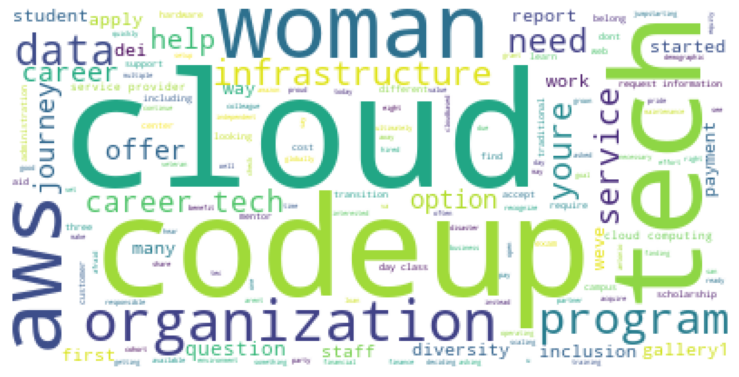

In [21]:
blog_img = WordCloud(background_color='white').generate(blog_words)
plt.imshow(blog_img)
plt.axis('off')

## 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

In [22]:
news_articles = aq.get_news_articles()
news_df = pd.DataFrame(news_articles)
news_df

,title,content,category
0,Bandhan Bank onboards Sourav Ganguly as brand ...,Bandhan Bank has announced Sourav Ganguly as i...,business
1,Musk is under federal probe over his conduct i...,Twitter has claimed that the world's richest p...,business
2,Layoffs will be the absolute last thing at Zoh...,Software startup Zoho's CEO Sridhar Vembu said...,business
3,Infosys let go of employees working for two co...,Infosys CEO Salil Parekh has revealed that the...,business
4,Centre announces one-time aide for paddy straw...,Centre said it'll provide one-time financial s...,business
...,...,...,...
94,"Was told I did 'Soch', 'Joker' for sympathy; c...",Singer Harrdy Sandhu said that he got messages...,entertainment
95,"When father takes care of child, society blows...","Actress Neha Dhupia said she finds it ""problem...",entertainment
96,"Mind-blowing, a must-watch: Dhanush on Rishab ...",Actor Dhanush took to Twitter to praise Rishab...,entertainment
97,Working with Salman Khan again in 'Tiger 3' is...,Speaking about working with actor Salman Khan ...,entertainment


In [23]:
bus_df = news_df[news_df.category == 'business']

In [24]:
bus_df.rename(columns={'content':'original'},inplace=True)
bus_df = pr.clean_df(bus_df)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [25]:
#Join the words together into one body of text
bus_words = ' '.join(bus_df['lemmatized'])

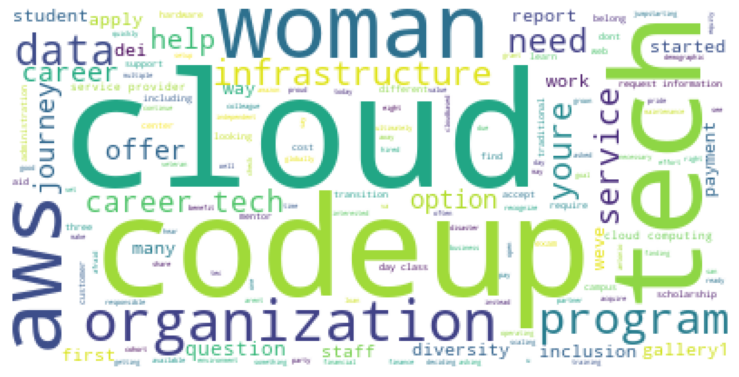

In [26]:
news_img = WordCloud(background_color='white').generate(bus_words)
plt.imshow(blog_img)
plt.axis('off')
plt.show()